# Ejercicio

Implementar los algoritmos de `VarianceThreshold`, `sklearn.feature_selection.f_regression`, y `sklearn.feature_selection.mutual_info_regression` al siguiente dataset para la selección de atributos.

Para el siguiente ejemplo utilizaremos un dataset de valores de propiedades (`housing_data.csv`). El mismo originalmente cuenta con 81 columnas. Para el proposito del ejercicio se le brinda el dataset con solo los atributos númericos. 

Luego de realizar el proceso de selección de atributos comparar los resultados y explicar el resultado asociado a cada método.

## Importar librerías

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix , recall_score , precision_score
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import f_regression, mutual_info_regression
import sklearn.metrics as metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

#TODO

## Importar dataset

### Comprendiendo los datos

`ID` =  Unique record ID  
`Gender` = Male/ Female  
`Married` = Applicant married (Y/N)  
`Dependents` = Number of dependents  
`Education` = Applicant Education (Graduate/ Under Graduate)  
`Self_Employed` = Self employed (Y/N)  
`ApplicantIncome` = Applicant income  
`CoapplicantIncome` = Coapplicant income  
`Credit_History` = Credit history meets guidelines(0- No, 1- Yes)  
`Property_Area` = Urban/ Semi Urban/ Rural  
`Loan_Applied` = Loan applied (Y/N)  

In [5]:
file = os.path.join('loan_data_set.csv')
df_loan_data=pd.read_csv(file)
df_loan_data.head()

,ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area,Loan_Applied
0,LP001002,Male,No,0,Graduate,No,5849,0.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,1.0,Urban,Y


In [6]:
df_loan_data.shape

(614, 11)

In [7]:
df_loan_data.dtypes

ID                    object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History       float64
Property_Area         object
Loan_Applied          object
dtype: object

In [8]:
## Incluir todos los atributos no solo los númericos
df_loan_data.describe(include='all') #TODO

,ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area,Loan_Applied
count,614,601,611,599,614,582,614.000000,601.000000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,3,2
top,LP001002,Male,Yes,0,Graduate,No,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1656.314343,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2947.927800,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1260.000000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2333.000000,1.000000,NaN,NaN


## Limpieza/Transformación dataset

In [9]:
# Calculamos los valores `ausentes` por columna
# Total de valores ausentes
mis_val = df_loan_data.isnull().sum()
        
# Porcentaje de valores ausentes
mis_val_percent = 100 * df_loan_data.isnull().sum() / len(df_loan_data)
        
# Tabla con los resultados
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
# Renombramos columnas
mis_val_table_ren_columns = mis_val_table.rename(
columns = {0 : 'Missing Values', 
           1 : '% of Total Values'})
        
# Ordenamos por porcentajes
mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
        
# Impresión de resultado
print ("El dataframe posee " + str(df_loan_data.shape[1]) + " columnas.\n"      
       "Existen" + " " + str(mis_val_table_ren_columns.shape[0]) +
       " columnas con datos ausentes")

El dataframe posee 11 columnas.
Existen 6 columnas con datos ausentes


In [10]:
mis_val_table_ren_columns

,Missing Values,% of Total Values
Credit_History,50,8.1
Self_Employed,32,5.2
Dependents,15,2.4
Gender,13,2.1
CoapplicantIncome,13,2.1
Married,3,0.5


### Ignorar/eliminar valores categóricos
>Si a una columna le faltan menos del 10% de sus valores, puede ignorarlo. Aunque esto es subjetivo al tamaño del conjunto de datos y al planteamiento del problema.

### Reemplace los valores numéricos con:
>1. Reemplazar con un valor arbitrario
>2. Reemplazar con la media: este es el método más común para imputar valores faltantes de columnas numéricas. Si hay valores atípicos, entonces la media no será apropiada. En tales casos, es necesario tratar primero los valores atípicos.
>3. Reemplazar con la moda: la moda es el valor que aparece con más frecuencia. Se utiliza en el caso de características categóricas.
>4. Reemplazar con la mediana: la mediana es el valor más intermedio. Es mejor utilizar el valor mediano para la imputación en el caso de valores atípicos.

In [11]:
df_loan_data[df_loan_data['CoapplicantIncome'].isnull()]

,ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area,Loan_Applied
15,LP001032,Male,No,0,Graduate,No,4950,NaN,1.0,Urban,Y
52,LP001164,Female,No,0,Graduate,No,4230,NaN,1.0,Semiurban,N
54,LP001186,Female,Yes,1,Graduate,Yes,11500,NaN,0.0,Urban,N
68,LP001238,Male,Yes,3+,Not Graduate,Yes,7100,NaN,1.0,Urban,Y
80,LP001265,Female,No,0,Graduate,No,3846,NaN,1.0,Semiurban,Y
114,LP001398,Male,No,0,Graduate,NaN,5050,NaN,1.0,Semiurban,Y
155,LP001536,Male,Yes,3+,Graduate,No,39999,NaN,0.0,Semiurban,Y
182,LP001636,Male,Yes,0,Graduate,No,4600,NaN,1.0,Semiurban,Y
247,LP001819,Male,Yes,1,Not Graduate,No,6608,NaN,1.0,Urban,Y
291,LP001938,Male,Yes,2,Graduate,No,4400,NaN,0.0,Semiurban,N


>Note: Para CoapplicantIncome, la media se utiliza para completar los valores de las columnas que faltan, ya que son los valores más utilizados para las columnas numéricas. Completar con valor promedio es una buena representación de la columna.

In [12]:
df_loan_data.CoapplicantIncome.fillna(df_loan_data.CoapplicantIncome.mean(),inplace=True)

In [13]:
df_loan_data[df_loan_data['ID'] == 'LP001041']

,ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area,Loan_Applied
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,1.0,Urban,Y


In [14]:
df_loan_data.dropna(how="any",inplace=True)

La columna `ID` es un número de autogenerador que no contiene información viable. Es específico para cada cliente y no afecta el estado de solicitud del préstamo. Las secuencias automáticas generalmente se eliminan con fines de modelado para evitar introducir datos que no tienen significado o peso para el resultado final.

In [15]:
df_loan_data.drop("ID",axis=1,inplace=True)

### ¿Qué es la codificación de etiquetas?

Es una forma sencilla y eficaz de convertir variables categóricas en forma numérica. Al utilizar la clase LabelEncoder de scikit-learn, puede codificar fácilmente sus datos categóricos y prepararlos para análisis posteriores o ingresarlos en algoritmos de aprendizaje automático.

Supongamos que tenemos una altura de columna en algún conjunto de datos que tiene elementos como Alto, Medio y Corto. Para convertir esta columna categórica en una columna numérica, aplicaremos codificación de etiqueta a esta columna. Después de aplicar la codificación de etiquetas, la columna Altura se convierte en una columna numérica que tiene los elementos 0,1 y 2, donde 0 es la etiqueta para alto, 1 es la etiqueta para mediano y 2 es la etiqueta para alto bajo.

#### Valor de altura
- alto 2
- Medio 1
- Corto 0

In [16]:
le = LabelEncoder()
df_loan_data["Gender"] = le.fit_transform(df_loan_data["Gender"])
df_loan_data["Married"] = le.fit_transform(df_loan_data["Married"])
df_loan_data["Dependents"] = le.fit_transform(df_loan_data["Dependents"])
df_loan_data["Self_Employed"] = le.fit_transform(df_loan_data["Self_Employed"])
df_loan_data["Education"] = le.fit_transform(df_loan_data["Education"])
df_loan_data["Property_Area"] = le.fit_transform(df_loan_data["Property_Area"])
df_loan_data["Loan_Applied"] = le.fit_transform(df_loan_data["Loan_Applied"])

In [17]:
df_loan_data.dtypes

Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History       float64
Property_Area          int32
Loan_Applied           int32
dtype: object

## Eliminación de outliers

En este paso determinar si es óptimo eliminar los outliers, ya sea por la cantidad respecto el dataset total, o si realmente pueden inferir negativamente en la clasificación.

In [19]:
algorithm = EllipticEnvelope(support_fraction=None, 
                             contamination=0.25, 
                             random_state=42) 

outlier_method = algorithm.fit(df_loan_data)
# Aplicamos el método de detección de outliers entrenado sobre nuesto dataset
df_outliers = outlier_method.predict(df_loan_data)
print(df_outliers)

# Determinar la posición de los outliers
pos_outliers = np.where(df_outliers==-1)[0] #En este arreglo, donde tengo -1, esos son los outliers.
"""
In simple terms, np.where(array==x)[0] returns a list of indices where the conditions have been met. I'm guessing this is a result of designing numpy for extensively broad applications.
"""

print('\nOutliers en la posición: \n', pos_outliers)

# Determinar el número de outliers
print('\nNúmero de outliers: \n', len(pos_outliers))

[ 1  1 -1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1  1
  1 -1  1 -1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1 -1  1
  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1
  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
 -1 -1 -1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1
  1 -1 -1 -1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1 -1
 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1 -1 -1 -1
 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1 -1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1
  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1
  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1

In [20]:
df_loan_data_wo_outliers = df_loan_data[df_outliers==1]

## Partición externa

In [21]:
X=df_loan_data_wo_outliers.drop(['Loan_Applied'],axis=1)
y=df_loan_data_wo_outliers['Loan_Applied']

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                           test_size=0.25,
                                           random_state=0)

## Selección de atributos (Feature selection)

In [23]:
mutual_info = mutual_info_regression(X_train, y_train)
print(mutual_info)
print(mutual_info.shape)

[0.02975481 0.         0.         0.03232757 0.         0.
 0.         0.15911296 0.01455246]
(9,)


<Axes: >

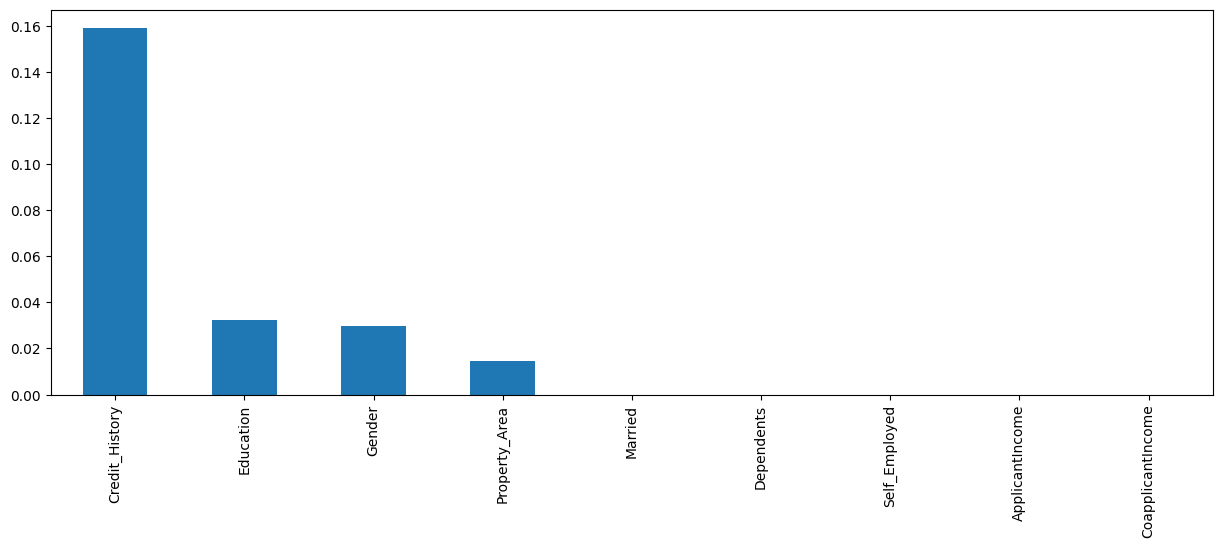

In [24]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

## Normalización/Estandarización

In [25]:
standardizer = preprocessing.StandardScaler() #TODO
X_train_std = standardizer.fit_transform(X_train) #TODO
print(X_train_std) 

[[-2.35004836 -1.26849947 -0.69384083 ... -0.89297914  0.3665888
  -1.35565013]
 [ 0.42552316  0.788333    2.46698961 ... -0.89297914 -2.72785199
  -0.05440736]
 [ 0.42552316  0.788333    1.41337946 ... -0.89297914  0.3665888
   1.24683541]
 ...
 [ 0.42552316  0.788333    0.35976932 ...  0.97372443  0.3665888
  -0.05440736]
 [ 0.42552316  0.788333   -0.69384083 ...  1.32278282  0.3665888
   1.24683541]
 [ 0.42552316  0.788333    0.35976932 ...  0.43821248  0.3665888
  -0.05440736]]


## Validación y evaluación del modelo

>Note: Evaluar el problema y utilizar un modelo basado en clasificación. En este caso recomendamos [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [ ]:
model=DecisionTreeClassifier() #TODO

In [ ]:
# Validación, entrenamiento y evaluación del algoritmo de aprendizaje.
# en "cv = KFold(n_splits=5)" estamos haciendo un cross-validation INTERNO!

"""
En results se hace la validación cruzada
"""

results = cross_val_score(model, 
                          X_train_std, 
                          y_train, 
                          cv = KFold(n_splits=5, shuffle = True, random_state = 42))

print("Resultados por bolsa: ", results)
print("Accuracy (media +/- desv.): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Resultados por bolsa:  [0.77586207 0.62068966 0.78947368 0.70175439 0.75438596]
Accuracy (media +/- desv.): 0.7284 +/- 0.0616


In [ ]:
y_pred = cross_val_predict(model, 
                          X_train_std, 
                          y_train, 
                          cv = KFold(n_splits=5, shuffle = True, random_state = 42))


In [ ]:
print("Exactitud: %.3f" % (metrics.accuracy_score(y_train, y_pred))) # accuracy
print("Precisión: %.3f" % (metrics.precision_score(y_train, y_pred, average="macro"))) # precision
print("Sensibilidad: %.3f" % (metrics.recall_score(y_train, y_pred, average="macro"))) # sensibilidad
print("F1-score: %.3f" % (metrics.f1_score(y_train, y_pred, average="macro"))) # F-score

Exactitud: 0.718
Precisión: 0.626
Sensibilidad: 0.634
F1-score: 0.630


In [ ]:
print("Matriz de confusión:\n", metrics.confusion_matrix(y_train, y_pred))

Matriz de confusión:
 [[ 33  37]
 [ 44 173]]


In [ ]:
print("Tabla de métricas:\n", metrics.classification_report(y_train, y_pred))

Tabla de métricas:
               precision    recall  f1-score   support

           0       0.43      0.47      0.45        70
           1       0.82      0.80      0.81       217

    accuracy                           0.72       287
   macro avg       0.63      0.63      0.63       287
weighted avg       0.73      0.72      0.72       287



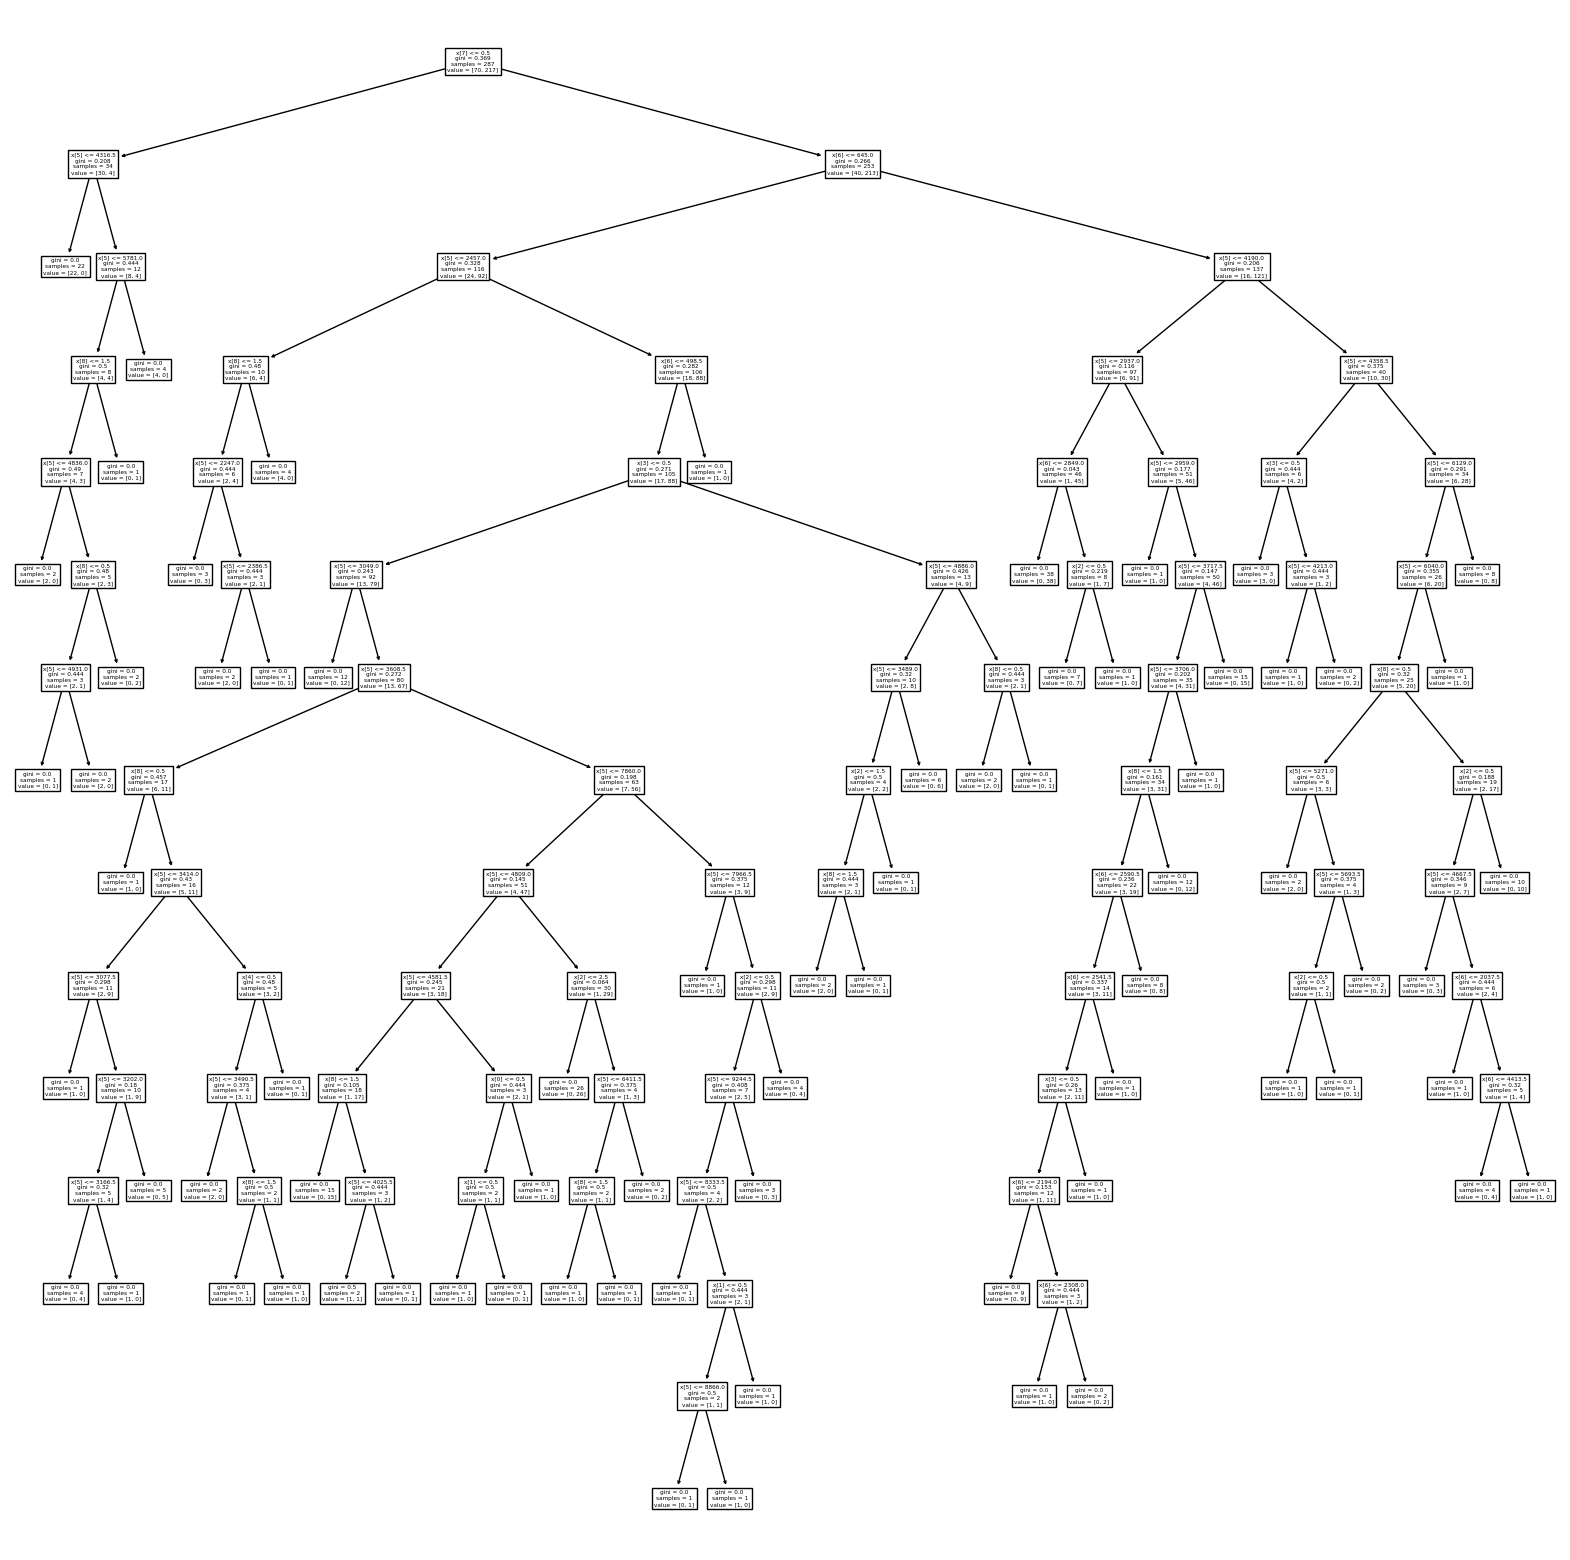

In [ ]:
# Para este ejemplo utilizaremos el algoritmo clasificador DecisionTreeClassifier
model.fit(X_train,y_train) #TODO
plt.figure(figsize=(20,20))
tree.plot_tree(model.fit(X_train,y_train))
plt.savefig("results/output.png")

In [ ]:
# Evaluación del modelo en test
dt_predict = model.predict(X_test) #TODO
print ('Accuracy:', accuracy_score(y_test, dt_predict)*100,"%")
print ('Precision:', precision_score(y_test, dt_predict,average='weighted')*100,"%")
print ('Recall:', recall_score(y_test, dt_predict,average='weighted')*100,"%")
print ('F1 score:', f1_score(y_test, dt_predict,average='weighted')*100,"%")

Accuracy: 76.04166666666666 %
Precision: 76.97611082518442 %
Recall: 76.04166666666666 %
F1 score: 76.4327582393276 %
